In [1]:
%matplotlib inline
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid.inset_locator import InsetPosition
from calculate_chi_func import chiCalc_custom


<ipython-input-1-6ddc1812ac72>:6: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import InsetPosition


In [2]:

true = [0.004, 0.48, 528, 0.0062, 8]
predicted = [2.15697613e-02, 4.27895351e-01, 5.32177220e+02, 8.85468023e-03, 8] #B fissata

In [3]:
def createSingleChi(parameters, returnT1=False): # nN: Number of pi pulses
    y0, a, B, w1, nN = parameters
    # Parameters of the control field
    #t1_vec = np.arange(0.1, 1.5, 0.002)  # Se va troppo lento usa questo
    # t1_vec = np.arange(0.1,2,0.002) # time vector for t1 [µs]
    t1_vec = np.array([0.2  , 0.204, 0.208, 0.212, 0.216, 0.22 , 0.224, 0.228, 0.232,
                   0.236, 0.24 , 0.244, 0.248, 0.252, 0.256, 0.26 , 0.264, 0.268,
                   0.272, 0.276, 0.28 , 0.284, 0.288, 0.292, 0.296, 0.3  , 0.304,
                   0.308, 0.312, 0.316, 0.32 , 0.324, 0.328, 0.332, 0.336, 0.34 ,
                   0.344, 0.348, 0.352, 0.356, 0.36 , 0.364, 0.368, 0.372, 0.376,
                   0.38 , 0.384, 0.388, 0.392, 0.396, 0.4  , 0.404, 0.408, 0.412,
                   0.416, 0.42 , 0.424, 0.428, 0.432, 0.436, 0.44 , 0.444, 0.448,
                   0.452, 0.456, 0.46 , 0.464, 0.468, 0.472, 0.476, 0.48 , 0.484,
                   0.488, 0.492, 0.496, 0.5  , 0.504, 0.508, 0.512, 0.516, 0.52 ,
                   0.524, 0.528, 0.532, 0.536, 0.54 , 0.544, 0.548, 0.552, 0.556,
                   0.56 , 0.564, 0.568, 0.572, 0.576, 0.58 , 0.584, 0.588, 0.592,
                   0.596, 0.6 ])
    totT_vec = 2 * nN * t1_vec  # total time vector [µs]

    # NSD function
    def funcGauss(x, y0, a, xc, w):
        return y0 + a * np.exp(
            -0.5 * ((x - 2 * np.pi * xc) / (2 * np.pi * w)) ** 2)  # I included a couple of 2*np.pi to convert \nu->


    def funcNoise(x, y0, a1, x1, w1):
        return y0 + funcGauss(x, 0, a1, x1,
                              w1)  # + funcGauss(x,0,a2,x2,w2) + funcGauss(x,0,a3,x3,w3) + funcGauss(x,0,a4,x4,w4)


    ## Function to calculate the distribution of pi pulses for a CPMG sequence
    def cpmg(t1, nN):
        seq = np.ones(nN + 1) * 2 * t1
        seq[0] = t1
        seq[-1] = t1  # [-1] indica l'elemento finale del vettore
        return seq


    showPlot = True  # False #
    saveData = False  # True #

    # NSD parameters
    vl = B * 1.0705e-3  # B*\gamma [MHZ]
    para = np.array([y0, a, vl, w1])  # [offset, amplitude, center, width] all in MHz

    ## Calculate chi at every total time
    chi = np.zeros(len(totT_vec))

    for i, totT in enumerate(totT_vec):
        ## Time between pulses
        t1 = totT / (2 * nN)

        ## pi pulses distribution
        pulses_times = cpmg(t1, nN).cumsum()[:-1]  # [:-1] <--- del vettore considerato si prendono tutti i valori all'infuori dell'ultimo

        ## Calculate chi
        chi[i] = chiCalc_custom(funcNoise, para, totT, pulses_times)

    parString = "{}_{}_{}_{}_{}".format(y0, a, B, w1, nN)

    if returnT1:
        return t1_vec, np.exp(-chi)
    else:
        # return np.float32(np.exp(-chi)), parString
        return np.exp(-chi), parString



# $C(t)$

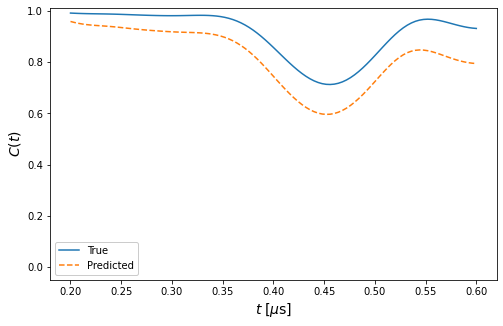

In [4]:
save = None
# save = "deliverableC.pdf"

fig = plt.figure(figsize=(8,5))

t1True, cohTrue = createSingleChi(true, returnT1=True)
t1Pred, cohPred = createSingleChi(predicted, returnT1=True)
plt.plot(t1True, cohTrue, label="True")
plt.plot(t1Pred, cohPred, '--', label="Predicted")

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
# plt.legend(bbox_to_anchor=(0.43, 0.3), loc='upper left', ncol=1, framealpha=1)
plt.legend(loc='lower left', ncol=1, framealpha=1)
plt.xlabel(r'$t \; [\mu{\rm s}]$',fontsize=14)
plt.ylabel(r'$C(t)$',fontsize=14)
plt.ylim(bottom=-0.05)
# plt.title("")
plt.show()

if not save is None:
    os.makedirs("img", exist_ok=True)
    fig.savefig('img/{}'.format(save), bbox_inches = 'tight')#, pad_inches = 0)
    print("Saved in 'img/{}'".format(save))

# $S(\omega)$

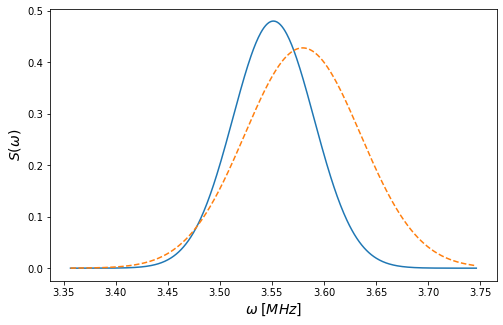

In [5]:
save = None
# save = "deliverableS.pdf"

fig = plt.figure(figsize=(8,5))

def funcGauss(x,y0, a,xc,w):
    return y0+a*np.exp(-0.5*((x-2*np.pi*xc)/(2*np.pi*w))**2) #I included a couple of 2*np.pi to convert \nu->

def funcNoise(x,y0,a1,x1,w1): # ,a2,x2,w2 ,a3,x3,w3 ,a4,x4,w4):
    return y0 + funcGauss(x,0,a1,x1,w1) #+ funcGauss(x,0,a2,x2,w2) + funcGauss(x,0,a3,x3,w3) + funcGauss(x,0,a4,x4,w4)

y0True, aTrue, BTrue, w1True, nNTrue = true
y0Pred, aPred, BPred, w1Pred, nNPred = predicted

γ=1.0705e-3 # C-13 nuclear spin gyromagnetic ratio

omega2 = 2*np.pi*np.linspace(γ*BTrue-5*w1True, γ*BTrue+5*w1True,500)
# omega2 = 2*np.pi*np.linspace(0.001, 8.5, 100000)

νlTrue = BTrue*γ # B*\gamma [MHZ]
para_ATrue=np.array([0.0, aTrue,νlTrue,w1True]) # [offset, amplitude, center, width] All in MHz
plt.plot(omega2,funcNoise(omega2,*para_ATrue))#,':.')

νlPred = BPred*γ # B*\gamma [MHZ]
para_APred=np.array([0.0, aPred,νlPred,w1Pred]) # [offset, amplitude, center, width] All in MHz
plt.plot(omega2,funcNoise(omega2,*para_APred), '--')#,':.')
plt.xlabel(r'$\omega \; [MHz]$',fontsize=14)
plt.ylabel(r'$S(\omega)$',fontsize=14)

if not save is None:
    os.makedirs("img", exist_ok=True)
    fig.savefig('img/{}'.format(save), bbox_inches = 'tight')#, pad_inches = 0)
    print("Saved in 'img/{}'".format(save))

# Both

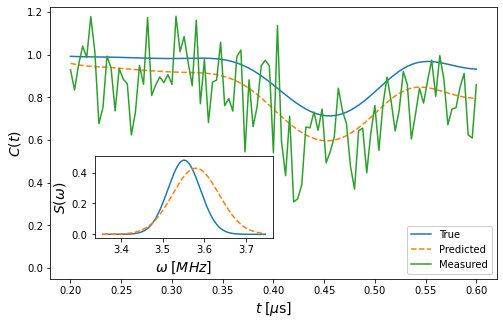

Saved in 'img/deliverable.pdf'


In [6]:
# save = None
save = "deliverable.pdf"

fig, ax1 = plt.subplots(figsize=(8,5))

# C
t1,coh,coh_err = np.loadtxt("real/XY8_N8_528G_from-old-data.dat")
t1True, cohTrue = createSingleChi(true, returnT1=True)
t1Pred, cohPred = createSingleChi(predicted, returnT1=True)
ax1.plot(t1True, cohTrue, label="True")
ax1.plot(t1Pred, cohPred, '--', label="Predicted")
ax1.plot(t1, coh, label="Measured")

# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
# ax1.legend(bbox_to_anchor=(0.43, 0.3), loc='upper left', ncol=1, framealpha=1)
ax1.legend(loc='lower right', ncol=1, framealpha=1)
ax1.set_xlabel(r'$t \; [\mu{\rm s}]$',fontsize=14)
ax1.set_ylabel(r'$C(t)$',fontsize=14)
ax1.set_ylim(bottom=-0.05)
# ax1.title("")

# S
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
# ip = InsetPosition(ax1, [0.51,0.15,0.45,0.5])
# ip = InsetPosition(ax1, [0.485,0.15,0.4,0.5])
ip = InsetPosition(ax1, [0.1,0.15,0.4,0.3])
ax2.set_axes_locator(ip)

def funcGauss(x,y0, a,xc,w):
    return y0+a*np.exp(-0.5*((x-2*np.pi*xc)/(2*np.pi*w))**2) #I included a couple of 2*np.pi to convert \nu->

def funcNoise(x,y0,a1,x1,w1): # ,a2,x2,w2 ,a3,x3,w3 ,a4,x4,w4):
    return y0 + funcGauss(x,0,a1,x1,w1) #+ funcGauss(x,0,a2,x2,w2) + funcGauss(x,0,a3,x3,w3) + funcGauss(x,0,a4,x4,w4)

y0True, aTrue, BTrue, w1True, nNTrue = true
y0Pred, aPred, BPred, w1Pred, nNPred = predicted

γ=1.0705e-3 # C-13 nuclear spin gyromagnetic ratio

omega2 = 2*np.pi*np.linspace(γ*BTrue-5*w1True, γ*BTrue+5*w1True,500)
# omega2 = 2*np.pi*np.linspace(0.001, 8.5, 100000)

νlTrue = BTrue*γ # B*\gamma [MHZ]
para_ATrue=np.array([0.0, aTrue,νlTrue,w1True]) # [offset, amplitude, center, width] All in MHz
ax2.plot(omega2,funcNoise(omega2,*para_ATrue))#,':.')

νlPred = BPred*γ # B*\gamma [MHZ]
para_APred=np.array([0.0, aPred,νlPred,w1Pred]) # [offset, amplitude, center, width] All in MHz
ax2.plot(omega2,funcNoise(omega2,*para_APred), '--')#,':.')
ax2.set_xlabel(r'$\omega \; [MHz]$',fontsize=14)
ax2.set_ylabel(r'$S(\omega)$',fontsize=14)

plt.show()

if not save is None:
    os.makedirs("img", exist_ok=True)
    fig.savefig('img/{}'.format(save), bbox_inches = 'tight')#, pad_inches = 0)
    print("Saved in 'img/{}'".format(save))

# MAE $C(t)$

In [7]:
np.mean(np.abs(cohTrue - cohPred))

0.09160627269487047

# MAE $S(\omega)$

In [8]:
np.mean(np.abs(funcNoise(omega2,*para_ATrue) - funcNoise(omega2,*para_APred)))


0.06785594545163161

# MRE $C(t)$

In [9]:
np.mean(np.abs(cohTrue - cohPred)/cohTrue)


0.10401517702043105

# MRE $S(\omega)$

In [10]:
np.mean(np.abs(funcNoise(omega2,*para_ATrue) - funcNoise(omega2,*para_APred))/funcNoise(omega2,*para_ATrue))




105.77290077039284